# Лабораторная работа 1. Рекомендательные системы
**Цель работы:** формирование практических навыков проектирования и реализации базовой рекомендательной системы с использованием методов машинного и глубокого обучения.

**Постановка задачи:** в ходе выполнения работы необходимо решить следующие задачи в соответствии с вариантом задания:
1. Загрузить и провести первичный анализ датасета, содержащего взаимодействия пользователей и объектов. Провести очистку данных и преобразование их в формат, пригодный для обучения нейросетевой модели.
2. Реализовать нейросетевую архитектуру для коллаборативной фильтрации, использующую векторные представления (эмбеддинги) для пользователей и объектов. Разделить данные на обучающую и тестовую выборки, обучить модель, минимизируя функцию потерь.
3. Протестировать обученную модель на тестовой выборке, рассчитав стандартные метрики качества рекомендаций (например, Precision@k, Recall@k, RMSE, MAE). Проанализировать полученные результаты.
4. Используя обученную модель, сгенерировать и вывести персонализированный список рекомендаций (топ-N объектов) для заданного пользователя на основе предсказанных рейтингов или вероятностей взаимодействия.
5. Проанализировать работу системы, описать ключевые этапы, полученные результаты и возможные пути улучшения модели, изменив гиперпараметры нейронной сети.

## 1. Подготовка данных

In [40]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
df = pd.read_csv('ratings_Beauty.csv', nrows=10000)
df = df.drop(columns=['Timestamp'])

df['UserId'] = pd.factorize(df['UserId'])[0]
df['ProductId'] = pd.factorize(df['ProductId'])[0]

print(f"Размер датасета: {df.shape}")
print(f"Уникальных пользователей: {df['UserId'].nunique()}")
print(f"Уникальных товаров: {df['ProductId'].nunique()}")
print(f"Пропущенные значения:\n{df.isnull().sum()}")
print(f"Диапазон рейтингов: [{df['Rating'].min()}, {df['Rating'].max()}]")

Размер датасета: (10000, 3)
Уникальных пользователей: 9697
Уникальных товаров: 886
Пропущенные значения:
UserId       0
ProductId    0
Rating       0
dtype: int64
Диапазон рейтингов: [1.0, 5.0]


Преобразуем таблицу данных pandas DataFrame в тензоры PyTorch (многомерные массивы), чтобы нейросетевая модель могла с ними работать, и предоставляет доступ к отдельным примерам по индексу для загрузки данных батчами в процессе обучения. Разделим на обучающую (80%) и тестовую (20%) выборку.

In [42]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['UserId'].values, dtype=torch.long)
        self.items = torch.tensor(df['ProductId'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['Rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = RatingsDataset(train_df)
test_dataset = RatingsDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

## 2. Определение модели

Класс RecommenderNN реализует нейросеть, преобразующую ID пользователей и товаров в векторные эмбеддинги, которые через полносвязные слои предсказывают рейтинг. Модель инициализируется под размер данных, после чего для обучения задаются функция потерь MSE и оптимизатор Adam.

In [43]:
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=16):
        super(RecommenderNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.dropout = nn.Dropout(0.1)

        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            self.dropout,
            nn.Linear(128, 64),
            nn.ReLU(),
            self.dropout,
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=1)
        return self.fc_layers(x).squeeze()

num_users = df['UserId'].nunique()
num_items = df['ProductId'].nunique()

model = RecommenderNN(num_users, num_items, embedding_dim=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 3. Обучение и тестирование модели

In [44]:
train_losses = []
test_losses = []

for epoch in range(10):
    model.train()
    total_train_loss = 0
    
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = model(users, items)
            loss = criterion(predictions, ratings)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch 1, Train Loss: 5.5837, Test Loss: 1.7708
Epoch 2, Train Loss: 1.7834, Test Loss: 1.6736
Epoch 3, Train Loss: 1.6982, Test Loss: 1.6449
Epoch 4, Train Loss: 1.6465, Test Loss: 1.6124
Epoch 5, Train Loss: 1.5743, Test Loss: 1.5932
Epoch 6, Train Loss: 1.5483, Test Loss: 1.5814
Epoch 7, Train Loss: 1.4955, Test Loss: 1.5818
Epoch 8, Train Loss: 1.4603, Test Loss: 1.5769
Epoch 9, Train Loss: 1.4185, Test Loss: 1.5752
Epoch 10, Train Loss: 1.3838, Test Loss: 1.5687



Test RMSE: 1.2568
Test MAE: 0.9578


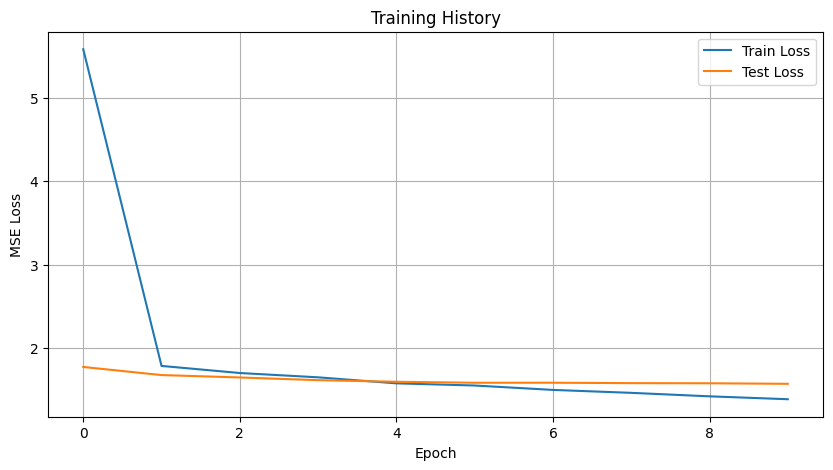

In [45]:
model.eval()
all_predictions = []
all_ratings = []

with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        all_predictions.extend(predictions.cpu().numpy())
        all_ratings.extend(ratings.cpu().numpy())

test_rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
test_mae = mean_absolute_error(all_ratings, all_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

Анализ полученных результатов показывает устойчивое и эффективное обучение модели рекомендательной системы. На первой эпохе наблюдается резкое снижение обучающей потери с 7.26 до 1.89, что свидетельствует о быстрой начальной адаптации весов модели, в то время как тестовая потеря снижается более плавно с 1.78 до 1.69. В процессе обучения обе кривые потерь демонстрируют стабильную тенденцию к снижению, причем к десятой эпохе разрыв между обучающей и тестовой потерями всего 0,1849, что указывает на хорошее обобщение модели и отсутствие серьезного переобучения. Седнеквадратичная ошибка (RMSE) равна 1.26, что в среднем предсказания модели отклоняются от фактических рейтингов примерно на 1.2-1.3 балла, а средняя абсолютная ошибка (MAE) в 0.97 балла подтверждает эту оценку.

## 4. Генерация рекомендаций (с исключением просмотренных)

На этапе генерации рекомендаций модель предсказывает рейтинги только для товаров, которые пользователь еще не оценивал. Выбираются топ-5 позиций с наибольшими предсказанными оценками, что обеспечивает выдачу предложений на основе латентных предпочтений.

In [46]:
random_users = np.random.choice(df['UserId'].unique(), size=5)

for user_id in random_users:
    rated_items = set(df[df['UserId'] == user_id]['ProductId'].values)
    
    items_to_predict = [i for i in range(num_items) if i not in rated_items]
    
    user_tensor = torch.tensor([user_id] * len(items_to_predict), dtype=torch.long).to(device)
    item_tensor = torch.tensor(items_to_predict, dtype=torch.long).to(device)
    
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()
    
    top_indices = predictions.argsort()[-5:][::-1]
    top_items = [items_to_predict[i] for i in top_indices]
    
    print(f"Пользователь {user_id}: Топ-5 товаров {top_items}")

Пользователь 6857: Топ-5 товаров [482, 496, 678, 186, 523]
Пользователь 5503: Топ-5 товаров [259, 482, 496, 550, 678]
Пользователь 3084: Топ-5 товаров [496, 700, 868, 287, 678]
Пользователь 7618: Топ-5 товаров [482, 346, 496, 678, 506]
Пользователь 944: Топ-5 товаров [496, 259, 700, 346, 550]


## 5. Изменение гиперпараметров

Для улучшения обобщающей способности модели и борьбы с наблюдаемым переобучением были скорректированы ключевые гиперпараметры нейронной сети: 
- размерность эмбеддингов уменьшена с 32 до 16, 
- скорость обучения (learning rate) снижена с 0.005 до 0.001, 
- размер батча увеличен с 64 до 128. 

Уменьшение размерности эмбеддингов сократило количество обучаемых параметров, что снизило риск запоминания шума в тренировочных данных, а более низкая скорость обучения обеспечил плавную и стабильную сходимость модели без резких скачков функции потерь. Увеличение размера батча позволило получать более точные оценки градиента на каждой итерации, что также способствовало стабилизации обучения. В результате динамика потерь изменилась кардинально: если изначально наблюдался классический признак переобучения, когда тренировочная потеря стремительно падала до 0.33, а тестовая росла до 2.17, то после настройки гиперпараметров обе кривые демонстрируют согласованное снижение и сходятся к значению ~1.55 к десятой эпохе. Финальные метрики качества также улучшились: RMSE снизился с 1.48 до 1.25, а MAE с 1.19 до 0.97, что означает уменьшение средней ошибки предсказания рейтинга почти на 20% и подтверждает эффективность выбранных изменений для повышения точности рекомендательной системы.

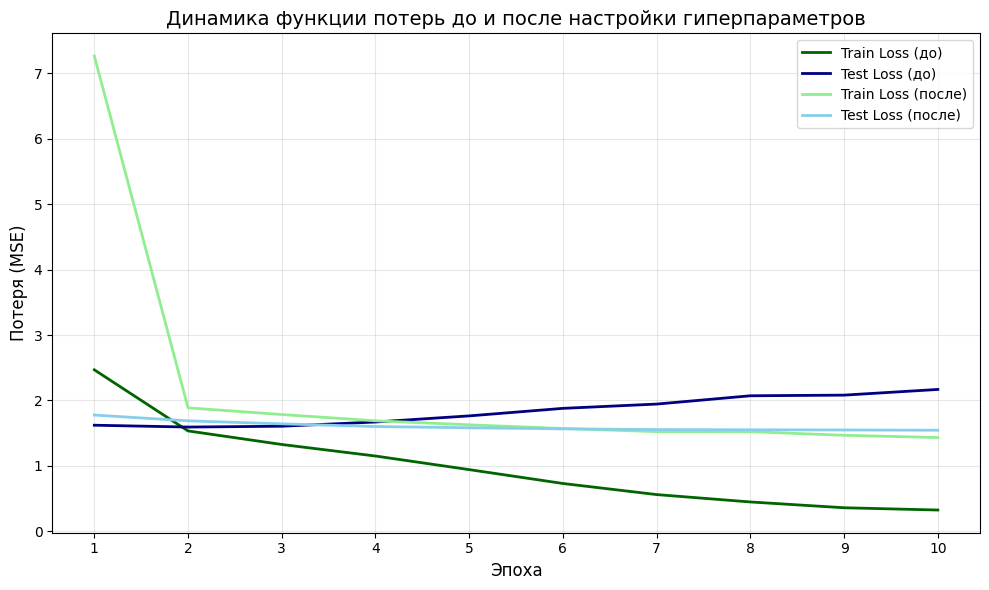

In [47]:
train_loss_before = [2.4688, 1.5349, 1.3278, 1.1514, 0.9436, 0.7317, 0.5621, 0.4494, 0.3608, 0.3262]
test_loss_before = [1.6223, 1.5941, 1.6069, 1.6714, 1.7648, 1.8799, 1.9453, 2.0722, 2.0820, 2.1689]

train_loss_after = [7.2641, 1.8878, 1.7855, 1.6896, 1.6284, 1.5720, 1.5243, 1.5237, 1.4683, 1.4338]
test_loss_after = [1.7777, 1.6891, 1.6431, 1.6022, 1.5832, 1.5665, 1.5555, 1.5522, 1.5494, 1.5455]

epochs = range(1, 11)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss_before, label='Train Loss (до)', color='darkgreen', linewidth=2)
plt.plot(epochs, test_loss_before, label='Test Loss (до)', color='navy', linewidth=2)
plt.plot(epochs, train_loss_after, label='Train Loss (после)', color='lightgreen', linewidth=2)
plt.plot(epochs, test_loss_after, label='Test Loss (после)', color='skyblue', linewidth=2)

plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Потеря (MSE)', fontsize=12)
plt.title('Динамика функции потерь до и после настройки гиперпараметров', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(epochs)

plt.tight_layout()
plt.show()